In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd

%matplotlib inline
ox.__version__


'1.2.1'

In [2]:
# credits to the Package Author!!

ox.utils.citation()

Citation:

Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems, 65, 126-139. https://doi.org/10.1016/j.compenvurbsys.2017.05.004

BibTeX entry for LaTeX users:

@article{boeing_osmnx_2017,
    title = {{OSMnx}: {New} {Methods} for {Acquiring}, {Constructing}, {Analyzing}, and {Visualizing} {Complex} {Street} {Networks}},
    volume = {65},
    doi = {10.1016/j.compenvurbsys.2017.05.004},
    number = {126-139},
    journal = {Computers, Environment and Urban Systems},
    author = {Boeing, Geoff},
    year = {2017}
}


In [3]:
# testing osmnx download capabilities
# ox.geometries_from_address('Jardim das Américas',{"highway":'footway'}).head()

In [4]:
WORKING_CRS = 'EPSG:31982'

In [5]:
# utw = ox.settings.useful_tags_way + ['smoothness','surface']
# ox.config(use_cache=True, log_console=True, useful_tags_way=utw)

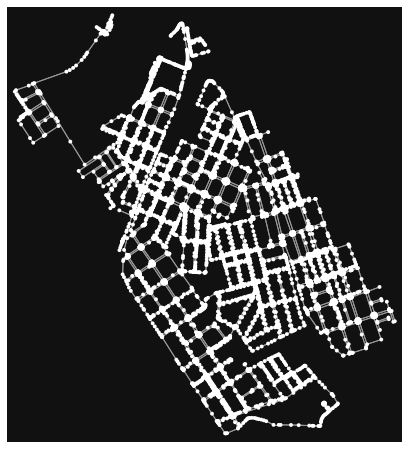

In [6]:
# test getting data using OSMNX:
G0 = ox.graph_from_place("Curitiba", 
# network_type="walk",
custom_filter='["footway"~"sidewalk|crossing"]',
simplify=False,
# retain_all=True,
)
fig, ax = ox.plot_graph(G0)

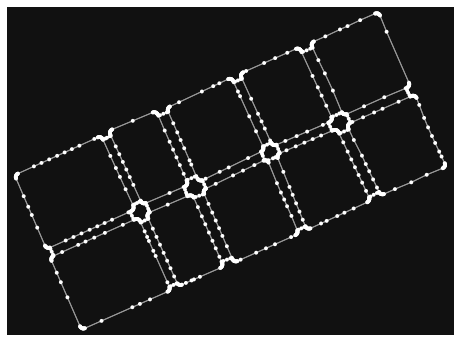

In [7]:
# -25.4646448, -49.2651410 S, W
# -25.4567635, -49.2570238 N, E
# test getting data using OSMNX:
G_tenblocks = ox.graph_from_bbox( -25.4567635,-25.4646448,-49.2570238,-49.2651410,
# network_type="walk",
custom_filter='["footway"~"sidewalk|crossing"]',
simplify=False,
# retain_all=True,
)
fig, ax = ox.plot_graph(G_tenblocks)

In [8]:
tenb_nodes, tenb_edges = ox.utils_graph.graph_to_gdfs(G_tenblocks)

In [9]:
# tenb_nodes.to_file('nodes_test.geojson')
# tenb_edges.to_file('edges_test.geojson')


In [10]:
# ox.folium.plot_graph_folium(G_tenblocks,popup_attribute='surface')

In [11]:
# to print edges data

# G.edges(data=True)

In [12]:
# gdf_nodes,gdf_edges = ox.utils_graph.graph_to_gdfs(G0)


# gdf_edges = gdf_edges.reset_index().head()

In [13]:
sidewalks_gdf = gpd.read_file('../data/sidewalks.geojson').set_index(['id']) #.to_crs(WORKING_CRS)
crossings_gdf = gpd.read_file('../data/crossings.geojson').set_index(['id']) #.to_crs(WORKING_CRS)
kerbs_gdf = gpd.read_file('../data/kerbs.geojson').set_index(['id']) #.to_crs(WORKING_CRS)

In [14]:
kerbs_gdf['final_score'].fillna(-30,inplace=True)
crossings_gdf['final_score'].fillna(0,inplace=True)
sidewalks_gdf['final_score'].fillna(0,inplace=True)

In [15]:
# checking final scores
kerbs_gdf['final_score'].unique()

array([ 50., -30.,  60.,   0.,  10.])

In [16]:
crossings_gdf['final_score'].unique()

array([ 51.93277311,  33.10344828,  13.10344828,  31.93277311,
        51.37614679,  48.86075949,  43.10344828,  61.93277311,
        27.53623188,   0.        , 120.        ,  28.86075949,
       130.        , 102.35294118, 114.73684211,  75.        ,
       100.        ,  94.73684211,  82.35294118])

In [17]:
sidewalks_gdf['final_score'].unique()

array([ 13.10344828,  31.93277311,  27.53623188,  28.86075949,
       100.        ,  29.88764045,   0.        ,  68.57142857,
        23.26530612,  31.37614679,  82.35294118,  94.73684211,
        74.66666667,  41.05263158,  46.15384615,  84.70588235,
        58.33333333,  66.66666667,  75.        ,  64.61538462,
        64.28571429,  42.85714286,  50.90909091,  55.38461538,
        43.63636364,  37.5       ,  17.5       ,  60.        ,
        33.33333333,  57.14285714,  27.27272727,  40.        ,
        18.        ])

In [18]:
from shapely.geometry import box

kerbs_buffered_gdf = kerbs_gdf.copy()

kerbs_buffered_gdf['geometry'] = kerbs_gdf.to_crs(WORKING_CRS).buffer(1).to_crs('EPSG:4326')

# for the sake of time, we will clip before following operations, in a future, the operation should be done to every feature

clipbox = box(*tenb_edges.total_bounds)

kerbs_buffered_gdf = gpd.clip(kerbs_buffered_gdf,clipbox)
crossings_gdf = gpd.clip(crossings_gdf,clipbox)
sidewalks_gdf = gpd.clip(sidewalks_gdf,clipbox)


In [19]:
crossings_extra_score = []


for index,crossing_row in crossings_gdf.iterrows():

    additional_score = 0


    for index2,kerb_row in kerbs_buffered_gdf.iterrows():
        # print(row['final_score'],row2['final_score'])

        if not kerb_row.geometry.disjoint(crossing_row.geometry):
            additional_score += kerb_row['final_score']

    crossings_extra_score.append(additional_score)

In [20]:
print(crossings_gdf['final_score'].unique())
crossings_gdf['final_score'] += crossings_extra_score
print(crossings_gdf['final_score'].unique())


[ 94.73684211 100.          82.35294118]
[ 34.73684211  64.73684211  40.          70.         114.73684211
  22.35294118 120.        ]


In [21]:
lines_gdf = pd.concat([sidewalks_gdf,crossings_gdf])

In [22]:
tenb_edges_joined = tenb_edges.reset_index().set_index('osmid').join(lines_gdf['final_score']).reset_index().set_index(['u','v','key']).drop(columns=['index']) #,lsuffix='_L',rsuffix='_R')

In [23]:
G = ox.utils_graph.graph_from_gdfs(tenb_nodes, tenb_edges_joined)

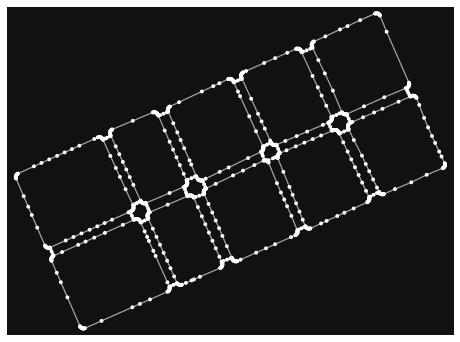

In [24]:
fig, ax = ox.plot_graph(G)

In [25]:
G = ox.elevation.add_node_elevations_raster(G,'elevation_data/cwb_dtm.tif')

In [26]:
G = ox.elevation.add_edge_grades(G, add_absolute=True)

In [27]:
# bouncing back to df to generate a TRULY final score

tenb_nodes2, tenb_edges2 = ox.utils_graph.graph_to_gdfs(G)


In [28]:
# tenb_edges2 = tenb_edges2.reset_index()

In [29]:
tenb_edges2['grade'].describe()

count    1.602000e+03
mean    -1.039535e-19
std      2.612949e-01
min     -2.808000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.808000e+00
Name: grade, dtype: float64

In [30]:
def signal_change(entry):
    if entry < -1.2:
        return -entry
    else:
        return entry

In [31]:
# accorsing to NBR ABNT 9050 the max allowed ramp is 12.5% slope, so there's no meaning in a lower weight for too sloped descents

tenb_edges2['corrected_grade'] = tenb_edges2['grade'].apply(signal_change)

In [32]:
tenb_edges2['beta_wh_weight'] = (tenb_edges2['length']/(tenb_edges2['final_score']+1)) * (1.0 + tenb_edges2['corrected_grade'])

# no negative weights
tenb_edges2['beta_wh_weight'] += (min(tenb_edges2['beta_wh_weight'])+0.0001)

In [33]:
round(max(tenb_edges2['beta_wh_weight']))+1

21

In [34]:
# setting any nan to the max computed weight plus one
tenb_edges2['beta_wh_weight'] = tenb_edges2['beta_wh_weight'].fillna(round(max(tenb_edges2['beta_wh_weight']))+1)

tenb_edges2['beta_wh_weight'].describe()

count    1602.000000
mean        0.112476
std         0.624825
min        -0.000471
25%         0.010112
50%         0.014764
75%         0.128392
max        19.597687
Name: beta_wh_weight, dtype: float64

In [35]:
tenb_edges2.to_file('sample_routing.geojson')

<AxesSubplot:>

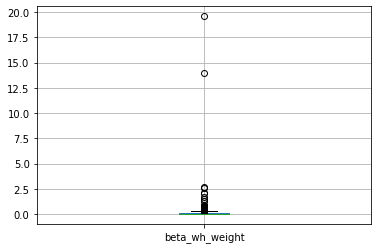

In [36]:
tenb_edges2.boxplot(column='beta_wh_weight')

In [37]:
# dict(G.nodes(data=True))  


In [38]:
# list(G.edges(data=True))

G_final = ox.utils_graph.graph_from_gdfs(tenb_nodes2, tenb_edges2)


In [39]:
# origin and destination sample vertex
# lat=-25.46098&lon=-49.26426
# lat=-25.46058&lon=-49.25854

orig = (-49.26426,-25.46098)
dest   = (-49.2606844,-25.4608760)

orig_nearest,orig_dist = ox.distance.nearest_nodes(G_final, *orig,return_dist=True)
dest_nearest,dest_dist = ox.distance.nearest_nodes(G_final, *dest,return_dist=True)

In [40]:
orig_nearest

9765548281

In [41]:
dest_nearest

9765548634

In [42]:
shortest = ox.distance.shortest_path(G_final,orig_nearest,dest_nearest,weight='beta_wh_weight')

In [49]:
polyline  = [(G_final.nodes[node_id]['y'],G_final.nodes[node_id]['x']) for node_id in shortest]

In [50]:
polyline

[(-25.4608659, -49.2642521),
 (-25.4608593, -49.2642546),
 (-25.4608524, -49.2642559),
 (-25.4608454, -49.2642561),
 (-25.4608384, -49.264255),
 (-25.4608317, -49.2642528),
 (-25.4608251, -49.2642493),
 (-25.4608196, -49.2642451),
 (-25.4608145, -49.2642398),
 (-25.4608131, -49.2642377),
 (-25.4608102, -49.2642337),
 (-25.4608068, -49.2642269),
 (-25.4607207, -49.2640167),
 (-25.4606799, -49.263917),
 (-25.460638, -49.2638148),
 (-25.4605952, -49.2637104),
 (-25.4605547, -49.2636114),
 (-25.4605153, -49.2635154),
 (-25.4604748, -49.2634166),
 (-25.4603941, -49.2632195),
 (-25.4603755, -49.2631743),
 (-25.4603731, -49.2631669),
 (-25.4603718, -49.2631593),
 (-25.4603716, -49.2631516),
 (-25.4603724, -49.2631442),
 (-25.4603724, -49.2631438),
 (-25.4603744, -49.2631364),
 (-25.4603774, -49.2631293),
 (-25.4603813, -49.2631229),
 (-25.4603861, -49.2631172),
 (-25.4603917, -49.2631124),
 (-25.4603978, -49.2631086),
 (-25.4604046, -49.2631043),
 (-25.4603894, -49.2630723),
 (-25.46038, -49.

In [43]:
shortest

[9765548281,
 9765548280,
 9765548279,
 9765548278,
 9765548277,
 9765548276,
 9765548274,
 9765548307,
 9765548306,
 9765548305,
 9765548303,
 9765548302,
 9765548304,
 9765548319,
 9765548318,
 9765548317,
 9765548316,
 9765548309,
 9765548308,
 9765548315,
 9765548314,
 9765548313,
 9765548312,
 9765548311,
 9765548310,
 9765548299,
 9765548298,
 9765548297,
 9765548296,
 9765548295,
 9765548294,
 9765548293,
 9765548863,
 9765548864,
 9765548865,
 9765548866,
 9765548867,
 9765548517,
 9765548518,
 9765548514,
 9765548515,
 9765548516,
 9765548507,
 9765548508,
 9765548859,
 9765548509,
 9765548510,
 9765548529,
 9765548531,
 9765548532,
 9765548533,
 9765548534,
 9765548535,
 9765548536,
 9765548537,
 9765548538,
 9765548829,
 9765548539,
 9765548838,
 9765548519,
 9765548520,
 9765548521,
 9765548522,
 9765548523,
 9765548524,
 9765548525,
 9765548526,
 9765548527,
 9765548528,
 9765548541,
 9765548542,
 9765548774,
 9765548775,
 9765548776,
 9765548777,
 9765548778,
 9765548382,

In [44]:
tenb_nodes2.loc[shortest].to_file('testing.geojson')

In [45]:
from shapely.geometry import LineString

route_linestring = LineString( [[a.x, a.y] for a in tenb_nodes2.loc[shortest].geometry.values] )

dummy_data = {'type':['route']}

route_gdf = gpd.GeoDataFrame(dummy_data,geometry=[route_linestring])

route_gdf.to_file('sample_route.gpx')

/home/kaue/.local/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [46]:
# exporting to graphml: 

ox.io.save_graphml(G_final,'routing_graph.graphml')